In [1]:
import numpy as np  
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam


from typing import Any , Literal
import warnings
warnings.filterwarnings(action = 'ignore' , category = DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set Seaborn style
sns.set_style("darkgrid")

C:\Users\AmirHussain\AppData\Local\Temp\ipykernel_9796\2973387298.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter


from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util import plotting



from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.operators.selection.tournament import TournamentSelection 

In [3]:
# Make Static List
from _collections_abc import dict_items, dict_keys, dict_values
from collections.abc import Iterator


class static_list(list):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.x = list()
        pass
    def __str__(self) -> str:
        return f"{self.x}"
    def __repr__(self) -> str:
        return f"static_list({self.x})"
    def __iter__(self) -> Iterator:
        return self.x.__iter__()
    
    def __len__(self) -> int:
        return len(self.x)
    
    def append(self, value : Any , sorted : bool = False):
        if len(self.x) == self.volume:
            self.x.append(  value )
            self.x.pop(0)
            self.x.sort(reverse = True) if sorted else None
        else :
            self.x.append(  value )
            self.x.sort(reverse = True) if sorted else None
        self.__repr__()
        pass
      
    def to_list(self) -> list:
        return self.x
    def to_numpy(self) -> np.ndarray :
        return np.array(self.x)


class static_dict(dict):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.solution = dict()
        pass
    def __str__(self) -> str:
        return f"{self.solution}"
    def __repr__(self) -> str:
        return f"static_dict({self.solution})"
    def keys(self) -> dict_keys:
        return list(self.solution.keys())
    def values(self) -> dict_values:
        return list(self.solution.values())
    def items(self) -> dict_items:
        return list(self.solution.items())
    def __iter__(self) -> Iterator:
        return self.solution.__iter__()
    
    def add(self, value : tuple):
        if len(self.solution) == self.volume:
            self.solution[value[0]] =  value[1]
            self.solution.pop( list(self.solution.keys()) [0])
        else :
            self.solution[value[0]] =  value[1]

        self.__repr__()
        pass

In [4]:
def initialize_population(population_size, num_variables, num_ojective):
    problem = Problem(n_var = num_variables, n_obj = num_ojective ,  xl=0, xu=1)
    sampling = FloatRandomSampling()
    X = sampling(problem, population_size).get("X")
    return X


Xg_ = initialize_population(100, 10, 3)
Xg_1 = initialize_population(100, 10, 3)


In [5]:
def binary_tournament(pop, P, **kwargs):
    # The P input defines the tournaments and competitors
    n_tournaments, n_competitors = P.shape

    if n_competitors != 2:
        raise Exception("Only pressure=2 allowed for binary tournament!")

    # the result this function returns

    S = np.full(n_tournaments, -1, dtype=np.int)

    # now do all the tournaments
    for i in range(n_tournaments):
        a, b = P[i]

        # if the first individual is better, choose it
        if pop[a].F < pop[b].F:
            S[i] = a

        # otherwise take the other individual
        else:
            S[i] = b

    return S

def tradition_EA(name , population, cross_over_rate, mutation_over_rate ):
    ref_point = 1 if name == 'ackley' else 3
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", ref_point, n_partitions=population.shape[0])
    # create the algorithm object
    algorithm = PSO(pop_size=None,
                    ref_dirs=ref_dirs,
                    sampling = population,
                    selection=TournamentSelection(func_comp=binary_tournament),
                     crossover=SBX( eta= 1 , prob= cross_over_rate ),
                     mutation=PM(eta=1, prob= mutation_over_rate ),)
    # execute the optimization
    problem = get_problem("ackley", n_var=population.shape[1], a=20, b=1/5, c=2 * np.pi) if name == "ackley" else get_problem(name, n_var=population.shape[1])

    res = minimize(problem,
                algorithm,
                seed=1,
                termination=('n_gen', 1))
    return res.X

In [6]:
# Xg_1 = initialize_population(100, 7, 10)
# print(Xg_1.shape)
# tradition_EA('dtlz1', Xg_, 1,1).shape

In [7]:
class learning_aided_evolution:
    def __init__(self,
                problem: Literal["dtlz1", "dtlz2", "dtlz3", "dtlz4",
                                "dtlz5", "dtlz6", "dtlz7", "ackley"] = "dtlz1",
                arch_size: int = 100,
                cross_over_rate: float = .5,
                mutation_rate: float = .9,
                n_obj: int = 3) -> None:
        self.problem = problem
        self.arch_size = arch_size
        self.cross_over_rate = cross_over_rate
        self.mutation_rate = mutation_rate
        self.n_obj = n_obj
        self.k = 1

        if problem in [ "dtlz2", "dtlz3", "dtlz4", "dtlz5", "dtlz6", "dtlz7", 'ackley' ]:
            self.n_var = 10
        elif problem in ['dtlz1']:
            self.n_var = 7
        else:
            raise Exception ("bad problem name")
    
    def cross_over(self, X_A, X_B, cross_over_rate):
        if np.random.rand() <= cross_over_rate:
            return X_A
        else:
            return X_B
        
    def mutation(self, X_A, X_B,X_C, ):
        """
        XA + cross_over_rate * (XB - Xc)
        """
        return X_A + self.mutation_rate * (X_B - X_C)

    def uniform_selection(self, population, k, ):  # population is a list of individuals
        population = population.tolist() if isinstance(population, np.ndarray) else population
        # generate the random array
        # use the choice method of the Generator class
        rng = np.random.default_rng()
        A_sampled = rng.choice(population, self.k)
        return A_sampled


    def run(self , Xg, newX ):
        newX = list()
        for i in range(1, len(Xg) ):
            LC = self.cross_over(Xg[1-i] , Xg[i ], self.cross_over_rate)
            newX.append(LC)

        for i in range(2, len(Xg) ):
            LM = self.mutation( Xg[i - 2], Xg[i - 1], Xg[i],)
            newX.append(LM)
        
        selection = self.uniform_selection( newX, self.k )
        return selection[-1] if self.problem == 'ackley' else selection


In [8]:
# initialize_ANN
def initialize_ANN(n_var, lr = 0.1 , active_function = 'softmax'):
# Create the modelweights_randomly
    # print(n_var, n_obj)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = n_var,
                              name = "Input"),
        tf.keras.layers.Dense(n_var * 3,
                              activation = 'sigmoid',
                              name = "hidden"),
        tf.keras.layers.Dense(n_var ,
                              activation = active_function,
                              name = "Output")
    ])

    model.compile(optimizer=Adam(lr), loss='mse')
    return model

In [9]:
# train_ANN
def train_ANN(model, X_train, y_train) -> np.ndarray:
    hist = model.fit(X_train, y_train, epochs=1, verbose=False)
    ypred = model.predict(X_train, verbose=False)
    return model, ypred[0] , hist.history['loss']


In [10]:
def MSE(arch_size, Lx, X):
    # Lx = np.argmax(Lx, axis=1)
    summ = np.sum(np.abs(Lx - X) ** 2)
    return (1/arch_size) * summ

In [11]:
def ackley(x, *args):
    x = np.asarray_chkfinite(x) 
    n = len(x)
    
    first_sum = 0.0
    second_sum = 0.0
    for c in x:
        first_sum += c**2.0  
        second_sum += np.cos(2.0*np.pi*c)

    return -20.0*np.exp(-0.2*np.sqrt(first_sum/n)) - np.exp(second_sum/n) + 20 + np.e



def dtlz1(x, n_obj, k=5):
    # x.reshape(1,1)
    # print(x.shape)
    g = 100*(k+np.sum((x[:,(n_obj-k):]-0.5)**2, axis=1))
    f = [0.5*np.prod(x[:,0:(n_obj-k)], axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(0.5*np.prod(x[:,0:(n_obj-k-i)], axis=1)*(1 - x[:,(n_obj-k-i-1)]*(1 + g))) 
    f.append(0.5*(1 - x[:,0])*(1 + g))
    return np.array(f).T


def dtlz2(x, n_obj, k=10):
    g = np.sum((x[:,(n_obj-k):]**2), axis=1)
    f = [np.prod(np.cos(x[:,0:(n_obj-k)]*np.pi/2), axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(np.prod(np.cos(x[:,0:(n_obj-k-i)]*np.pi/2), axis=1)*(1 + g))
    f.append((1 + g)*np.sin(x[:,0]*np.pi/2))
    return np.array(f).T

def dtlz3(x, n_obj, k=10):
    g = 100*(k+np.sum((x[:,(n_obj-k):]-0.5)**2, axis=1))  
    f = [np.prod(x[:,0:(n_obj-k)], axis=1)*(1 + g)]
    for i in range(n_obj-k-1):
        f.append(np.prod(x[:,0:(n_obj-k-i)], axis=1)*(1 + g)) 
    f.append((1 + g)*np.sin(x[:,0]*np.pi/2))
    return np.array(f).T
    
def dtlz4(x, n_obj, alpha=100):
    g = np.sum((x[:,(n_obj-1):]**2), axis=1)
    f = [np.prod(np.cos(x[:,0:(n_obj-1)]**alpha * np.pi/2), axis=1)*(1 + g)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(x[:,0:(n_obj-2-i)]**alpha * np.pi/2), axis=1)*(1 + g)) 
    f.append(np.sin(x[:,0]**alpha * np.pi/2))
    return np.array(f).T


def dtlz5(x, n_obj, g=None):
    if g is None:
        g = np.sum((x[:,(n_obj-1):]-0.5)**2, axis=1)        
    theta = x[:,0:(n_obj-1)]*np.pi/2
    f = [np.prod(np.cos(theta), axis=1)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(theta[:,0:(n_obj-2-i)]), axis=1)) 
    f.append(np.sin(theta[:,0]))
    f = np.array(f).T
    return (1 + g.reshape(-1,1))*f

def dtlz6(x, n_obj, alpha=100):
    g = np.sum(x[:,(n_obj-1):]**alpha, axis=1) 
    theta = x[:,0:(n_obj-1)]*np.pi/2
    f = [np.prod(np.cos(theta), axis=1)]
    for i in range(n_obj-2):
        f.append(np.prod(np.cos(theta[:,0:(n_obj-2-i)]), axis=1))
    f.append(np.sin(theta[:,0])) 
    f = np.array(f).T
    return (1 + g.reshape(-1,1))*f
    
def dtlz7(x, n_obj, g=None):
    if g is None:
        g = 1 + 9*np.mean(x[:,(n_obj-1):], axis=1) 
    f = [x[:,0]]
    for i in range(n_obj-2):
        f.append(x[:,i+1])
    f.append((1 + g)* (n_obj - np.sum(x[:,0:(n_obj-1)], axis=1)/(n_obj-1))) 
    return np.array(f).T

In [12]:
def fitness(name : str, 
            indivisual: np.ndarray , 
            n_objective: int) -> float| np.ndarray:
    match name:
        case "dtlz1":
            return dtlz1( indivisual , n_objective)
        case "dtlz2":
            return dtlz2( indivisual , n_objective)
        case "dtlz3":
            return dtlz3( indivisual , n_objective)
        case "dtlz4":
            return dtlz4( indivisual , n_objective)
        case "dtlz5":
            return dtlz5( indivisual , n_objective)
        case "dtlz6":
            return dtlz6( indivisual , n_objective)
        case "dtlz7":
            return dtlz7( indivisual, n_objective)
        case "ackley":
            return ackley( indivisual , n_objective)
        case _ :
            raise ValueError("bad arg")
        
        
def time_fitness(function, *args, **kwargs):
  start_time = time.time()
  LX = function(*args, **kwargs)
  end_time = time.time()
  time_delay = (end_time - start_time) / 1000 
  return time_delay , LX

In [13]:
def is_better(problem : str,
                individual_1 : np.ndarray,
                individual_2 : np.ndarray,
                n_objective : int) -> tuple[bool, np.ndarray]:
    
    fitness_individual_1 = fitness( problem, 
                                    individual_1,
                                    n_objective)
    
    fitness_individual_2 = fitness( problem, 
                                    individual_2,
                                    n_objective)

    if np.any(fitness_individual_1 < fitness_individual_2):
        
        return True , individual_1
    else:
        return False , individual_2

In [14]:
# Second Suggestion Seletion Function
def uniform_selection( population, k, ):  # population is a list of individuals
    population = population.tolist() if isinstance(population, np.ndarray) else population
    # generate the random array
    # use the choice method of the Generator class
    rng = np.random.default_rng()
    A_sampled = rng.choice(population, k)
    return A_sampled

In [15]:
def main(
    Problem : object,
    archive_size : int,
    lp : float,
    n_generations : int,
    first_gen_size : int,
    n_obj : int,
    n_var : int,
    cross_over_rate : float,
    mutation_rate : float,
    ANN_learning_rate : float,
    ANN_Activatvation_function : Literal['sigmoid' , 'softmax'],
    plot : bool
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    


    Xg  : np.ndarray = initialize_population(first_gen_size, n_var, n_obj )  # Initialize population and evaluate fitness
    ANN = initialize_ANN(1 if Problem == 'ackley' else n_obj , 
                         ANN_learning_rate , ANN_Activatvation_function )  # Initialize ANN weights randomly
    archive = static_list(archive_size)  # Archive to store solution pairs
    trained_solutions = static_list(archive_size)
    all_losses = static_list(archive_size)

    leo = learning_aided_evolution(Problem, 
                                   archive_size, 
                                   cross_over_rate, 
                                   mutation_rate, 
                                   n_obj)
    # newX = Xg
    for gen in range(n_generations):
        leo.k = 1 if Problem == "ackley" else Xg.shape[0]

        r = np.random.uniform(0,1)
        if gen > 1 and r < lp:
            newX = leo.run(Xg, newX)

        else :
            newX = tradition_EA(Problem, Xg, cross_over_rate, mutation_rate )

        # print(Xg.shape, newX.shape)

        Xg_i = uniform_selection(newX , newX.shape[0])
        # print(Xg_i)
        # SEP Collection
        better = is_better(Problem, Xg_i, newX, n_obj)[1]
        # print(better.shape)
        for i, v in enumerate(better) :
            if v in Xg_i:
                archive.append((Xg_i[i], newX[i]))
                break
            elif v in newX:
                archive.append((newX[i], Xg_i[i]))


        for x1, x2 in archive:
            # print(x1.reshape(1,-1).shape, x2.reshape(1,-1).shape)
            ANN, traind, loss = train_ANN(ANN, x1.reshape(1,-1), x2.reshape(1,-1))
            trained_solutions.append(traind)
            all_losses.append( loss[0] )

        print(f"gen{gen+1}=", end= "")

    archive = archive.to_numpy()


    loss = np.sum(all_losses) / archive_size
    if plot:
        fig, ax = plt.subplots(1,3 , figsize=(15, 5))
        sns.scatterplot(Xg,            legend=False , ax=ax [0] )
        ax[0].set_xlabel('initialize population' , fontsize = 10)
        ax[0].set_ylabel('f (x)', fontdict = {'font': 'Times new Roman'})

        ax[0].grid(visible =True)

        sns.scatterplot(trained_solutions.to_list(), legend=False , ax=ax [1] )
        ax[1].set_xlabel('solution for Problem' , fontsize = 10)
        ax[1].set_ylabel('f (x)', fontdict = {'font': 'Times new Roman'})
        ax[1].grid(visible =True)

        sns.lineplot(all_losses,    legend=False , ax=ax [2] )
        ax[2].set_xlabel('MSE loss ' , fontsize = 10)

        plt.title('Output of Algorithm')
        ax[2].grid(visible =True)
        plt.savefig(f"data-{Problem}-{n_obj}.png")
        plt.savefig(f"data-{Problem}-{n_obj}.svg")

        plt.show()
    
    return archive, np.array(trained_solutions), loss
     

In [16]:
PROBLEM =  'ackley'
ARCHIVE_SIZE = 1000
LP = .5
N_GENERATORS = 10
FIRST_GEN_SIZE = 100
CROSS_OVER_RATE = .5
MUTATION_RATE = .9
N_OBJ = 3
N_VAR = 100
ANN_LR = .1
ANN_AC_FUNCTION = 'sigmoid'




gen1=gen2=gen3=gen4=gen5=gen6=gen7=gen8=gen9=gen10=

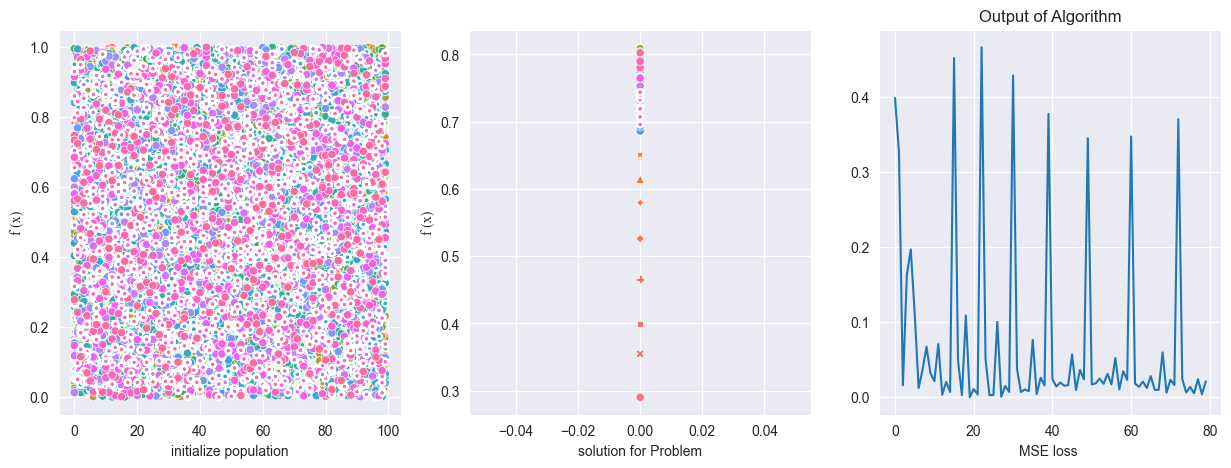

In [17]:
Archive , Solutions, loss = main(
    PROBLEM,
    archive_size = ARCHIVE_SIZE,
    lp = LP,
    n_generations = N_GENERATORS, # number of generations
    first_gen_size = FIRST_GEN_SIZE, # number of generations 
    cross_over_rate = CROSS_OVER_RATE, # cross over rate
    mutation_rate = MUTATION_RATE, # mutation rate 
    n_obj= N_OBJ, # number of observations
    n_var= N_VAR, # number of variables
    ANN_learning_rate = ANN_LR, # learning rate
    ANN_Activatvation_function= ANN_AC_FUNCTION, # activation function for ANN
    plot = True,
)

In [18]:
print(loss)
Archive.shape

0.005586879827482335


(13, 2)

In [19]:
arc_1 = np.array([i for i, _ in Archive])
arc_2 = np.array([j for  _, j in Archive])

In [20]:
%matplotlib qt

In [21]:
%matplotlib inline

In [22]:
print(Solutions[:5])

[[0.29005653]
 [0.3545657 ]
 [0.39906055]
 [0.46567556]
 [0.52607155]]


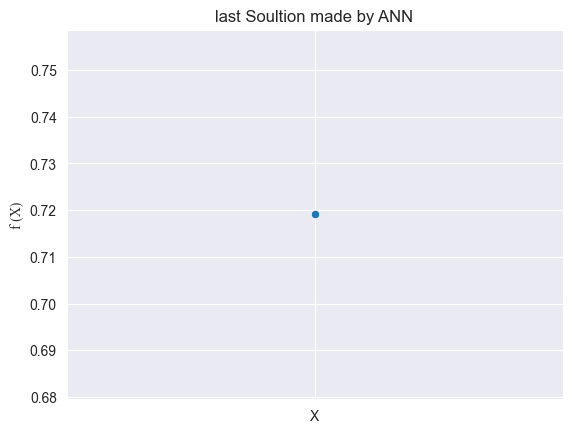

In [23]:


sns.scatterplot(pd.DataFrame(
    {"X"  :Solutions[-1,:] }
).T
,
legend=False)

plt.title("last Soultion made by ANN")


plt.ylabel('f (X)', fontdict = {'font': 'Times new Roman'})
# plt.xlabel('num of Objectvies (X)')
plt.savefig("Archive.png")
plt.savefig("Solutions.svg")
plt.show()

In [24]:
arc_1

array([0.20382881, 0.86075278, 0.56803598, 0.32470648, 0.60995204,
       0.86075278, 0.77663183, 0.23725237, 0.5082604 , 0.19510019,
       0.97481769, 0.16729921, 0.88081738])

In [25]:

pd.DataFrame( Archive,
              ).to_excel("Archive 1.xlsx")

pd.DataFrame( arc_2,
              ).to_excel("Archive 2.xlsx")

pd.DataFrame(
    Solutions 
).to_excel("ANN sulotion.xlsx")

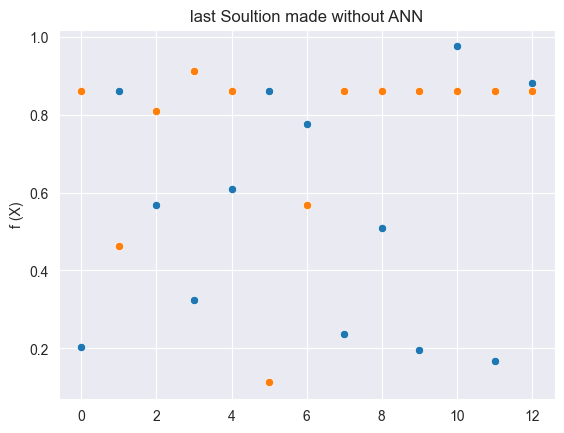

In [26]:
sns.scatterplot(arc_1
, legend=False)

sns.scatterplot(arc_2
, legend=False)
plt.title("last Soultion made without ANN")
plt.ylabel('f (X)')
# plt.xlabel('num of Objectvies (X)')
plt.savefig("Archive.png")
plt.savefig("Archive.svg")
plt.grid(visible=True)
plt.show()

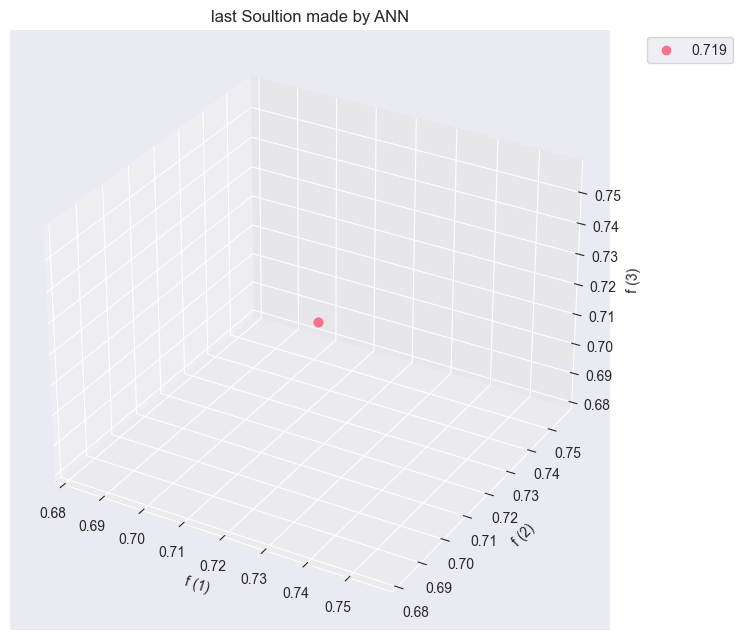

In [27]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter3D(Solutions[-1,:], 
                  Solutions[-1,:],
                  Solutions[-1,:],
              c = Solutions[-1,:], 
                   s = 40, 
                   marker = 'o', 
                   cmap = cmap , 
                   alpha = 1)

plt.title("last Soultion made by ANN")
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


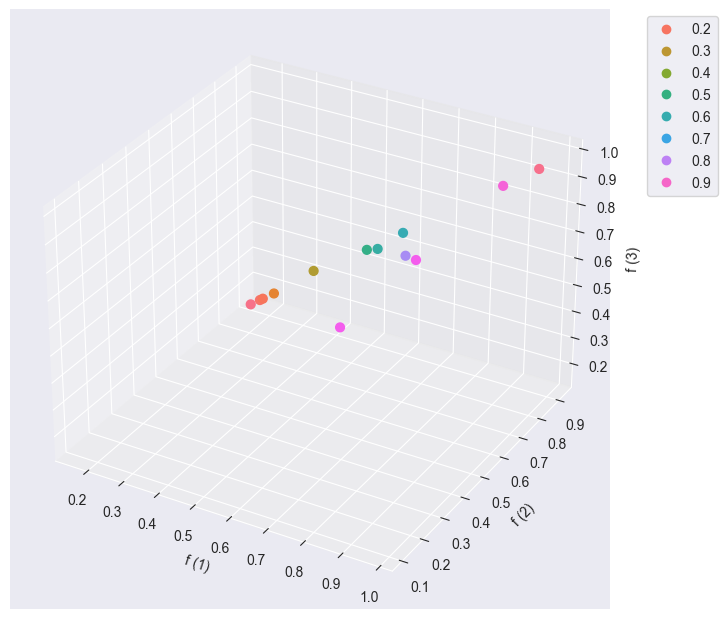

In [30]:


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter(arc_1, 
                arc_2,
                arc_1,
            c = arc_1, s=40, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


In [38]:
Solutions.reshape(1,-1)[0]
arc_1

array([0.20382881, 0.86075278, 0.56803598, 0.32470648, 0.60995204,
       0.86075278, 0.77663183, 0.23725237, 0.5082604 , 0.19510019,
       0.97481769, 0.16729921, 0.88081738])

In [39]:
import scipy.stats as stats

arc_solution = pd.DataFrame({
    'solution' : Solutions[-1,:],
    "archive 1" :Archive[-1,-2,:],
    'Archive 2' : Archive[-1,-1,:]
})

# One-sided test (alternative hypothesis: sample1 > sample2)
statistic, pvalue_greater = stats.wilcoxon(arc_solution, 
                                    alternative='greater')
print("One-sided p-value:", pvalue_greater)

# Two-sided test (alternative hypothesis: not equal medians)
statistic, pvalue_two_sided = stats.wilcoxon(arc_solution, 
                                   alternative='two-sided')
print("Two-sided p-value:", pvalue_two_sided)

One-sided p-value: [0.00012207 0.00012207]
Two-sided p-value: [0.00024414 0.00024414]


In [40]:
# Perform Kruskal-Wallis test
import scipy.stats as stats

group1 = Solutions[-1,:]
group2 = Archive[-1,-2,:]
group3 = Archive[-1,-1,:]


k_stat, p = stats.kruskal(group1, group2, group3
                          )

print(f"""
kstat   => {k_stat :.2f} 
p value => {p :.2f}
""")

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Only proceed to Cohon test if Kruskal-Wallis test is significant 
if p < 0.05:
    # Extract sum of ranks of each group
    n1 = len(group1)
    sum_rank1 = stats.rankdata(group1).sum()
    
    n2 = len(group2)
    sum_rank2 = stats.rankdata(group2).sum()

    n3 = len(group3) 
    sum_rank3 = stats.rankdata(group3).sum()

    # Compare sum of ranks between pairs using z statistic 
    z_12 = (sum_rank1 - sum_rank2)/np.sqrt(n1*n2*(n1+n2+1)/12)
    z_13 = (sum_rank1 - sum_rank3)/np.sqrt(n1*n3*(n1+n3+1)/12)
    z_23 = (sum_rank2 - sum_rank3)/np.sqrt(n2*n3*(n2+n3+1)/12)
    
    # Compare to critical value
    crit = 1.96
    p_12 = 2 * (1 - stats.norm.cdf(abs(z_12))) 
    p_13 = 2 * (1 - stats.norm.cdf(abs(z_13)))
    p_23 = 2 * (1 - stats.norm.cdf(abs(z_23)))

    # Print significant results
    print(p_12, p_13, p_23)

1.0 1.0 1.0


In [43]:
import pandas as pd
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi



# Perform the Friedman test
friedman_result = friedmanchisquare(
                                    Solutions[-1,:],
                                    arc_1[-1], 
                                    arc_2[-1], 
                                    # df['solution'].to_numpy(),
                                    # df['Archive 1'].to_numpy(),
                                    # df['Archive 2'].to_numpy()

                                    )
print(friedman_result.pvalue)
# If significant, proceed with post-hoc analysis
if friedman_result.pvalue < 0.05:
    posthoc_result = posthoc_nemenyi(Solutions)
    print(posthoc_result)
    posthoc_result.to_excel('posthoc_result.xlsx',)
    
else:
    print("No significant differences detected.")



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 13